<h1><center>Data Analysis</center></h1>
<h2><center>Kaggle report notebook</center></h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process.kernels import RBF
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from collections import Counter
from xgboost import XGBClassifier

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Introduce yourself

Put your team name and team-members' names below

**Team "Dinar Ivan Valery"**

**Dinar Faiskhanov, 162-2**

**Ivan Fefelov, 162-1**

**Valery Kotlyar, 162-2**

# Task

In this task we are working with posts on famous russian advertisement and resell platform.

Ginen information about the post and corresponding item you have to estimate its probability to be sold in 3 days.

Below you will find some desirable stages of your report.

# Data Loading

In [2]:
data = pd.read_csv('./train.tsv.gz', sep='\t', index_col=0)
test_data = pd.read_csv('./test_nolabel.tsv.gz', sep='\t', index_col=0)

In [3]:
data.columns

Index(['category_id', 'city', 'date_created', 'delivery_available',
       'desc_text', 'img_num', 'lat', 'long', 'name_text', 'owner_id',
       'payment_available', 'price', 'product_id', 'product_type',
       'properties', 'region', 'sold_mode', 'subcategory_id', 'sold_fast'],
      dtype='object')

# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

In [4]:
print("Number of objects: ", data.shape[0])
print("Number of features: ", data.shape[1])

print("\nNumber of unique values for:")
for feature_name in data.columns:
    # Feature values
    feature_values = data[feature_name].values
    # Target labels
    labels = data['sold_fast'].values
    # Unique values
    unique, counts = np.unique(feature_values, return_counts=True)
    print(feature_name+": ", len(unique))

Number of objects:  351281
Number of features:  19

Number of unique values for:
category_id:  24
city:  2299
date_created:  289
delivery_available:  2
desc_text:  333976
img_num:  20
lat:  74798
long:  109704
name_text:  212239
owner_id:  305336
payment_available:  2
price:  2861
product_id:  351281
product_type:  3
properties:  89835
region:  109
sold_mode:  2
subcategory_id:  281
sold_fast:  2


C:\Users\faiskhanov.KL\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\faiskhanov.KL\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


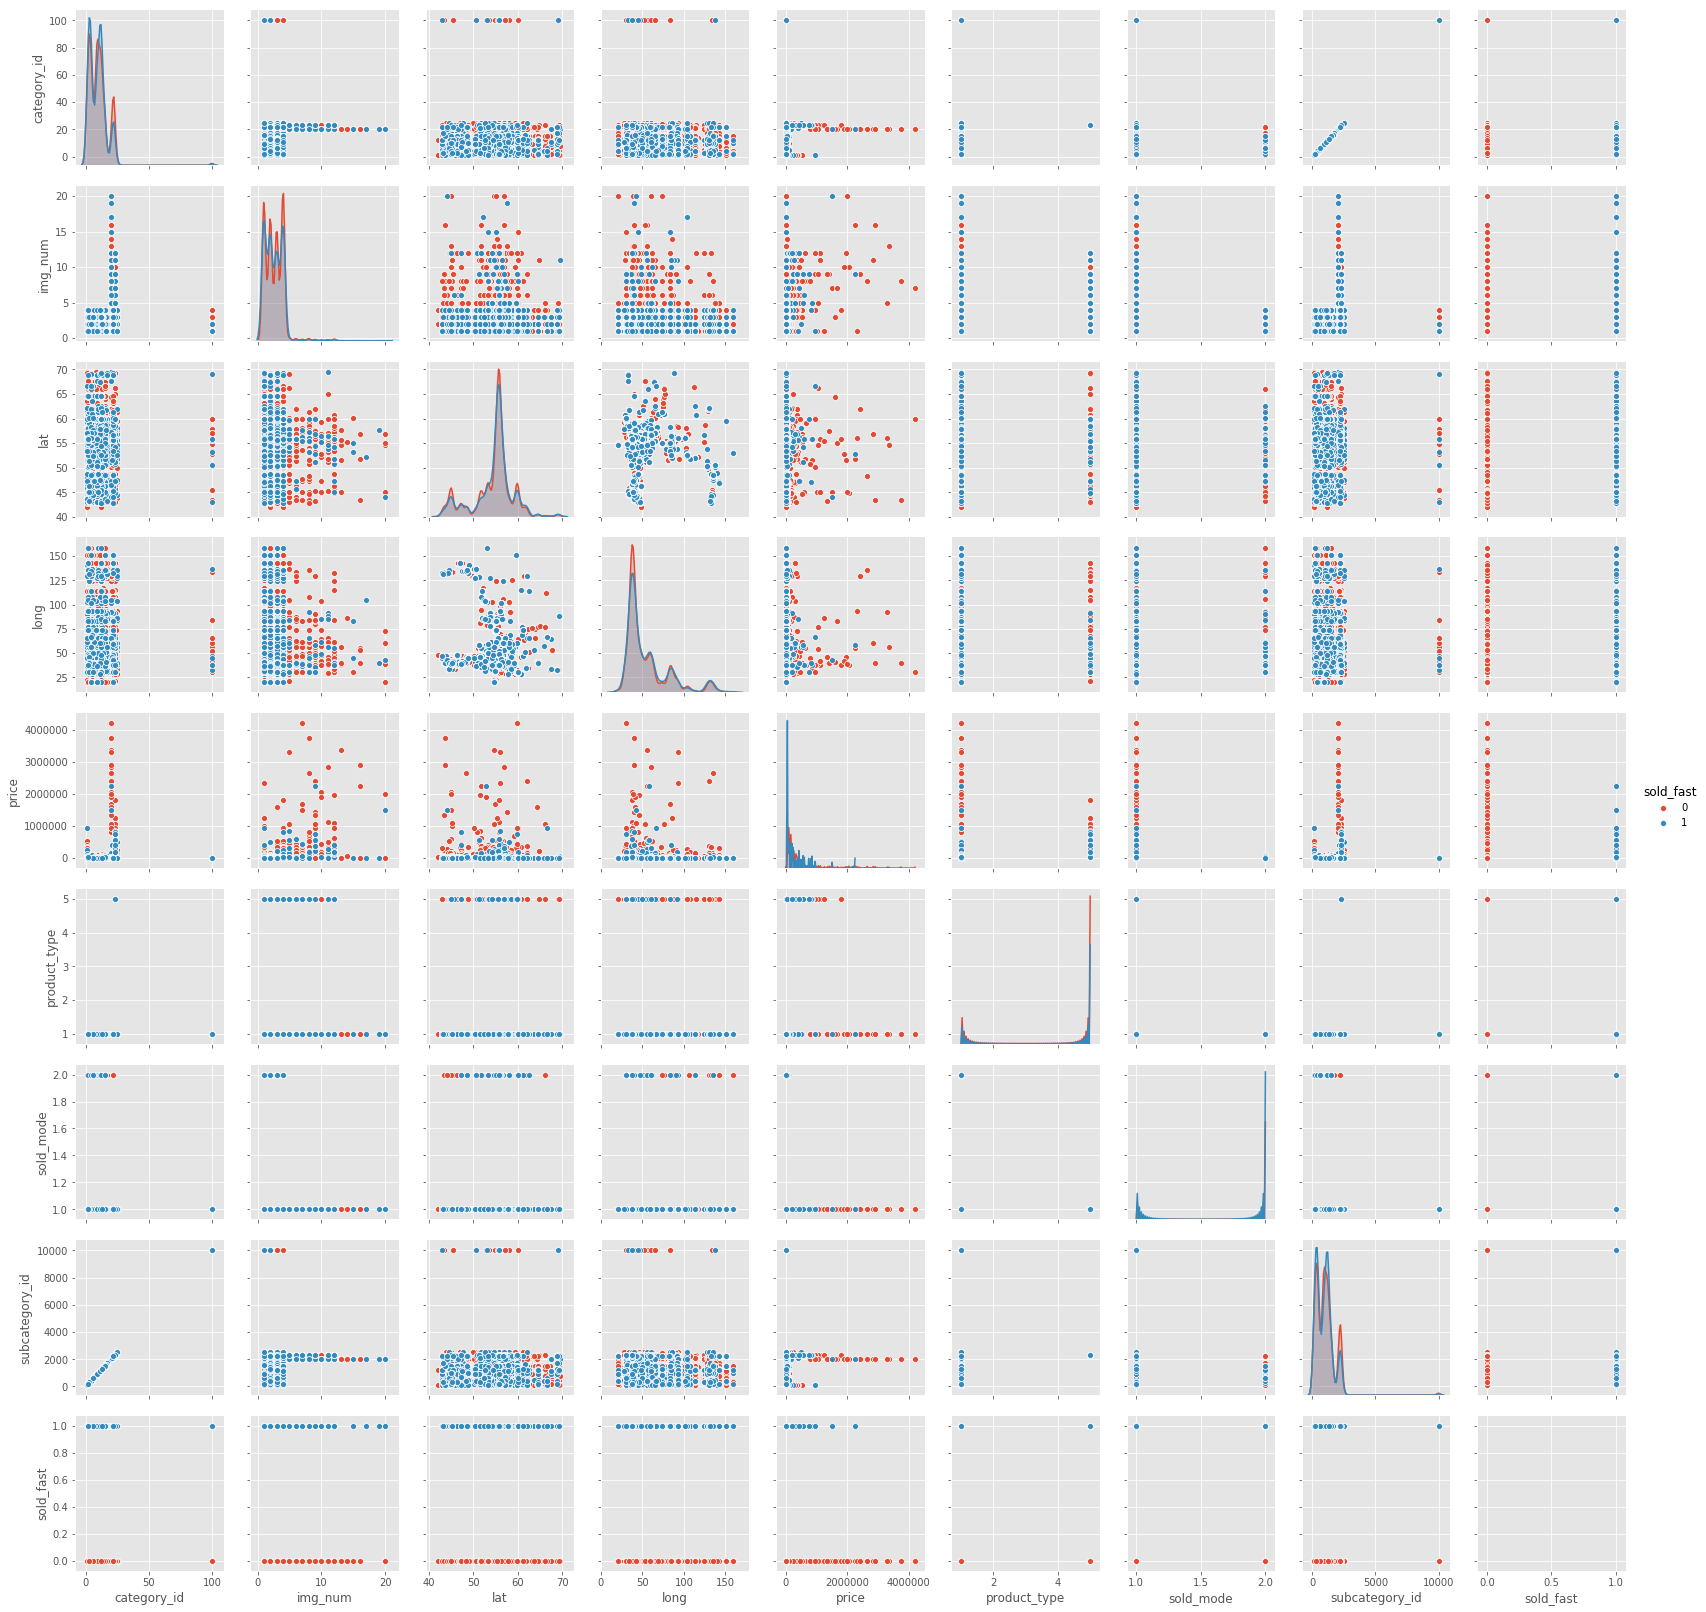

In [5]:
df_numeric_cols = data.iloc[0:10000].select_dtypes(include=['float64', 'int64'])
sns_plot = sns.pairplot(df_numeric_cols, hue='sold_fast')
sns_plot.savefig("pairplot.png")

We don't see strong correlation between any numeric features

Correlation is only between:
- category_id and subcategory_id;
- category_id and product_type;
- img_num and subcategory_id;
- img_num and product_type.

**Also, we can notice that more img_num means more probability of sold_fast**

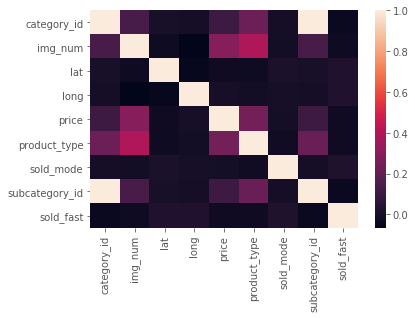

In [6]:
sns.heatmap(df_numeric_cols.corr())

From the crosstab of delivery_available and sold_fast we can see that availability of delivery positively correlates with target variable.

**There is greater percent of products with available delivery when sold_fast=1.**

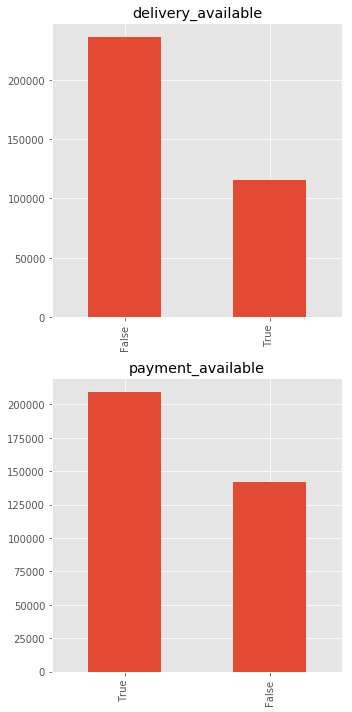

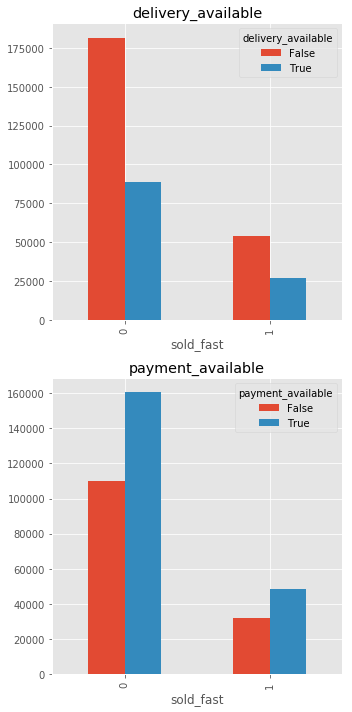

In [7]:
df_bool_cols = data.select_dtypes(include=['bool'])
features_list = df_bool_cols.columns.tolist()

fig, axes = plt.subplots(len(features_list), 1, figsize=(5, 10))
for i, feature in enumerate(features_list):
    ax = axes[i]
    data[feature].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(feature)
fig.tight_layout()
fig.savefig('bool_features_distributions_1.png')

fig2, axes2 = plt.subplots(len(features_list), 1, figsize=(5, 10))
for i, feature in enumerate(features_list):
    ax = axes2[i]
    pd.crosstab(data['sold_fast'], data[feature]).plot(kind='bar', ax=ax)
    ax.set_title(feature)
fig2.tight_layout()
fig2.savefig('bool_features_distributions_2.png')


Number of regions -  109 



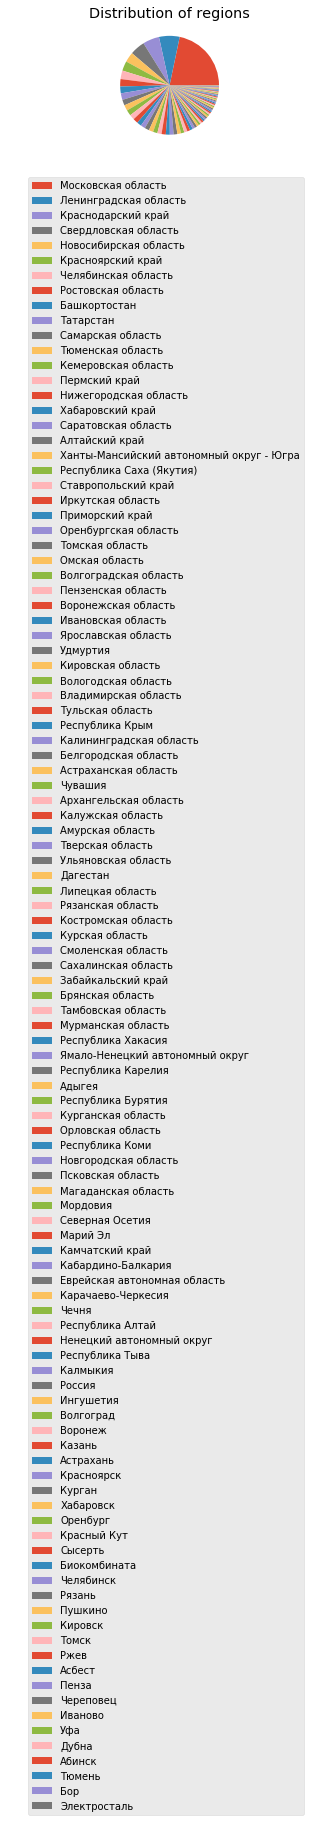

In [8]:
regions_pie_df = data['region'].value_counts()
fig = plt.figure(2, figsize=(5,5))
regions_pie_ax = fig.add_subplot(211) 
regions_pie_ax.set_title('Distribution of regions')
regions_pie = regions_pie_ax.pie(list(regions_pie_df.values), startangle=0)
regions_pie_legend_ax = fig.add_subplot(212) 
regions_pie_legend_ax.axis("off")
regions_pie_legend_ax.legend(regions_pie[0], list(regions_pie_df.index))
fig.savefig('regions_distributions.png')
print("\nNumber of regions - ", len(regions_pie[0]), "\n")

We can easily use one hot encoding for regions (only 109 uniqe values)


Number of cities -  2299 



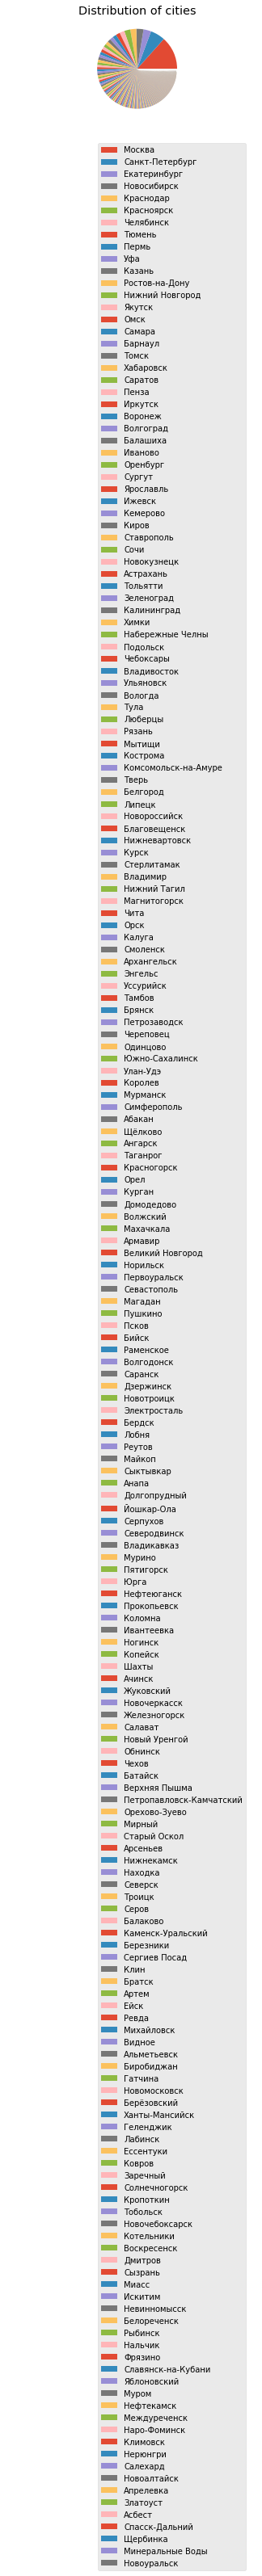

In [9]:
cities_pie_df = data['city'].value_counts()
fig = plt.figure(2, figsize=(5,5))
cities_pie_ax = fig.add_subplot(211) 
cities_pie_ax.set_title('Distribution of cities')
cities_pie = cities_pie_ax.pie(list(cities_pie_df.values), startangle=0)
cities_pie_legend_ax = fig.add_subplot(212) 
cities_pie_legend_ax.axis("off")
cities_pie_legend_ax.legend(cities_pie[0], list(cities_pie_df.index)[:200])
print("\nNumber of cities - ", len(cities_pie[0]), "\n")

We can see that the number of cities is too large (>2000), so one hot encoding will greatly increase the number of features.

It is possible to divide cities into groups (sorted by frequency for example)

# Machine-learning pipeline and prediction

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

In [10]:
# MinMax normalization.
def normalize(data, column_name):
    x = data[[column_name]].values.astype(float)

    min_max_scaler = preprocessing.MinMaxScaler()

    x_scaled = min_max_scaler.fit_transform(x)

    df_normalized = pd.DataFrame(x_scaled)
    data[[column_name]] = df_normalized
    
# Decompose column into n parts.
# Values are sorted by the number of appearances.
def split_column(data, second_data, name, part_count=5):
    values = data[name]
    counter = Counter(values)
    uniqs = np.unique(values.append(second_data[name]))
    part_length = math.floor(len(uniqs)/part_count)
    
    parts = []
    for i in range(part_count):
        start_part = counter.most_common(i * part_length)
        
        end_part = counter.most_common((i + 1) * part_length)
        if(i == (part_count - 1)):
            end_part = counter.most_common(len(uniqs))
            
        part = list(set(end_part) - set(start_part))
        part = [row[0] for row in part]
        parts.append(part)
    
    for i in range(part_count):
        data[name + "_" + str(i)] = np.array([int(value in parts[i]) for index, value in enumerate(data[name].values)])
        
# Simple one hot encoding.
def split_one_hot(data, second_data, name):
    values = data[name]
    uniqs = np.unique(values.append(second_data[name]))
    
    for val in uniqs:
        data[name + "_" + str(val)] = np.array([int(value == val) for index, value in enumerate(data[name].values)])

In [11]:
def prepare_data(data, second_data, take=100):
    df = data
    
    #saving productIs
    product_ids = df.iloc[0:take]['product_id'].values
    data['desc_len'] = np.array([len(value) for index, value in enumerate(df['desc_text'].values)]) 
    
    df['payment_available'] = np.array([int(value) for index, value in enumerate(df['payment_available'].values)])
    df['delivery_available'] = np.array([int(value) for index, value in enumerate(df['delivery_available'].values)])
    df['name_text_len'] = np.array([len(value) for index, value in enumerate(df['name_text'].values)]) 
    df['properties_len'] = np.array([len(value) for index, value in enumerate(df['properties'].values)]) 

    split_column(df, second_data, 'city', 700)
    split_one_hot(df, second_data, 'region')
    split_one_hot(df, second_data, 'subcategory_id')
    split_one_hot(df, second_data, 'category_id')
    split_one_hot(df, second_data, 'sold_mode')
    split_one_hot(df, second_data, 'product_type')
    
    
    inf_data = df.drop(["product_id", "desc_text", "city", "name_text", "owner_id", 
                        'properties', 'region', 'category_id', 'lat', 'long', 'product_type',
                        'subcategory_id', 'sold_mode', 'date_created'], axis=1)
    
    normalize(inf_data, 'price')
    normalize(inf_data, 'desc_len')
    normalize(inf_data, 'name_text_len')
    normalize(inf_data, 'properties_len')
    normalize(inf_data, 'img_num')

    return inf_data.iloc[0:take], product_ids

In [12]:
def get_X_y(inf_data, train=True):
    y = None
    if train:
        X = inf_data.drop(['sold_fast'], axis=1).values
        y = 1. *(inf_data['sold_fast'].values)
    else:
        feature_names = inf_data.columns
        X = inf_data.values
    
    return X, y

In [13]:
# Preparing train data.
inf_data, product_ids = prepare_data(data, test_data, len(data))
X, y = get_X_y(inf_data)
print('feature count - ', len(inf_data.columns))
inf_data.head()

feature count -  1132


,delivery_available,img_num,payment_available,price,sold_fast,desc_len,name_text_len,properties_len,city_0,city_1,...,category_id_23,category_id_24,category_id_25,category_id_100,sold_mode_1,sold_mode_2,product_type_1,product_type_5,product_type_7,product_type_8
1,0,0.052632,1,3.000000e-08,1,0.037472,0.071429,0.013593,0,1,...,0,0,0,0,1,0,1,0,0,0
2,0,0.000000,0,1.100000e-07,0,0.030023,0.071429,0.032739,0,0,...,0,0,0,0,1,0,1,0,0,0
4,1,0.052632,1,2.000000e-07,0,0.018059,0.267857,0.000000,0,0,...,0,0,0,0,1,0,1,0,0,0
6,0,0.000000,1,1.000000e-10,0,0.008804,0.214286,0.013739,1,0,...,0,0,0,0,1,0,1,0,0,0
10,0,0.105263,1,1.000000e-06,0,0.047178,0.446429,0.028939,1,0,...,0,0,0,0,1,0,1,0,0,0


In [14]:
C = 10
classifier = XGBClassifier(n_estimators=1000, learning_rate=0.02, max_depth=3, n_jobs=3,
                           colsample_bytree=0.5, scale_pos_weight=1., subsample=0.5)

In [15]:
classifier.fit(X, y)
accuracy = accuracy_score(y, classifier.predict(X))
print("Accuracy (train) for %s: %0.1f%% " % ("L1 logistic", accuracy * 100))

Accuracy (train) for L1 logistic: 83.0% 


In [16]:
# Preparing test data.
test_data_prepared, test_product_ids = prepare_data(test_data, data, len(test_data))
X_test, _ = get_X_y(test_data_prepared, train=False)
print('feature count - ', len(test_data_prepared.columns))
test_data_prepared.head()

feature count -  1131


,delivery_available,img_num,payment_available,price,desc_len,name_text_len,properties_len,city_0,city_1,city_2,...,category_id_23,category_id_24,category_id_25,category_id_100,sold_mode_1,sold_mode_2,product_type_1,product_type_5,product_type_7,product_type_8
0,1,0.105263,1,6.500000e-08,0.037012,0.145833,0.081095,0,0,1,...,0,0,0,0,1,0,1,0,0,0
3,1,0.052632,1,1.000000e-08,0.023341,0.312500,0.000000,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8,0,0.052632,1,1.500000e-07,0.041681,0.604167,0.047594,0,0,0,...,0,0,0,0,1,0,1,0,0,0
9,1,0.105263,1,7.500000e-08,0.001334,0.250000,0.139325,1,0,0,...,0,0,0,0,1,0,1,0,0,0
19,1,0.052632,1,3.000000e-07,0.024008,0.895833,0.033768,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [17]:
y_test = classifier.predict_proba(X_test)

In [18]:
import csv

y_test = np.array([value[1] for index, value in enumerate(y_test)])
write_data = [test_product_ids, y_test]

write_data = list(map(list, zip(*write_data)))

In [19]:
with open("postsold-prediction/result.csv", "w") as output:
    output.write("product_id,score\n")
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(write_data)

# Сonclusion

We examined followings graphs: 
- Correlation (heatmap) 
- Pairplot 
- Distributions of boolean and numeric features 
- Distributions of cities, regions 
- Pairplot of target variable and price

We have tried following models: 
- AdaBoostClassifier 
- GaussianNB 
- LinearDiscriminantAnalysis 
- QuadraticDiscriminantAnalysis 
- LogisticRegression 
- XGBClassifier

For us the best one - **XGBClassifier**